# Practical work 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [139]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

# Useful functions 
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = 2*np.int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()


## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale, kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussianKernel()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [14]:
Gsobel = np.array([[1,0,-1], [2,0,-2], [1,0,-1]])

In [25]:
def computeR(image,scale,kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    #Computation of the directionnal derivate 𝐼𝑥 and 𝐼𝑦, Use the Sobel kernel.
    Ix = scipy.signal.convolve2d(image, Gsobel, 'same')
    Iy  = scipy.signal.convolve2d(image, Gsobel.T, 'same')
    
    #Computation of the products 𝐼2𝑥, 𝐼2𝑦, 𝐼𝑥.𝐼𝑦
    IxIy = Ix * Iy
    Ix2 = Ix * Ix
    Iy2 = Iy * Iy

    #Computation of the convolution of 𝐼2𝑥, 𝐼2𝑦 and 𝐼𝑥.𝐼𝑦 by a gaussian kernel of size N (use given function gaussianKernel())
    w = gaussianKernel(scale)
    wIxIy = scipy.signal.convolve2d(IxIy,w, 'same')
    wIx2 = scipy.signal.convolve2d( Ix2,w, 'same')
    wIy2 = scipy.signal.convolve2d(Iy2,w, 'same')

    #Computation of det(𝑀(𝑥,𝑦)) and trace(𝑀(𝑥,𝑦)) for each pixel
    det = np.zeros(image.shape)
    trace = np.zeros(image.shape)
    det=wIx2*wIy2-wIxIy**2
    trace=wIx2+wIy2
    
    #Computation of 𝑅(𝑥,𝑦)=det(𝑀(𝑥,𝑦))−𝑘.(trace(𝑀(𝑥,𝑦)))2. You can use 𝑘=0.04.

    R=np.zeros(image.shape)
    R=det-kappa*(trace**2)
    return R

2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

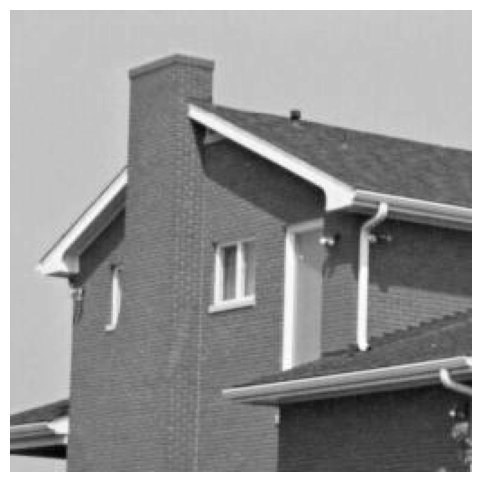

/tmp/ipykernel_4950/1582708496.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n2 = np.int(np.ceil(3*sigma))


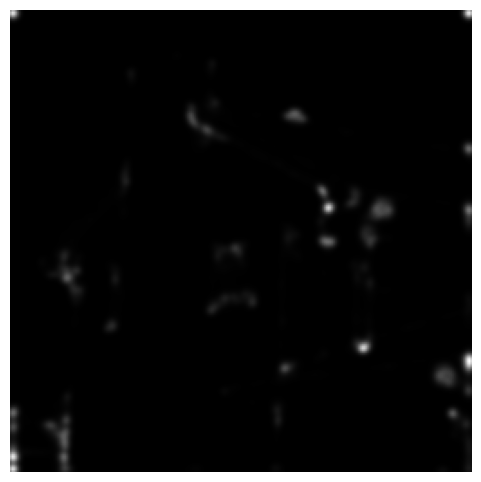

In [58]:
house = np.array(Image.open("img/house2.png"))
imshow(house)
#W = 2 * np.ceil(3*sig)  = 14
#np.ceil(3*sig)  = 7
#sig = 7/3 = 2.3 
harryshouse = computeR(house,2.3, 0)
imshow(harryshouse)

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

The corners are white (very high values), the edges are black (of value 0) and the homogeneous regions are dark grey (close to 0).
Harris response didn't allow us to detect the edges on top of the chimney. This is probably explained because the contrast between the chimney and the sky is less intense than the other borders.
Also, we notice that some areas are (falsly) detected as corners close to the image borders.


## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

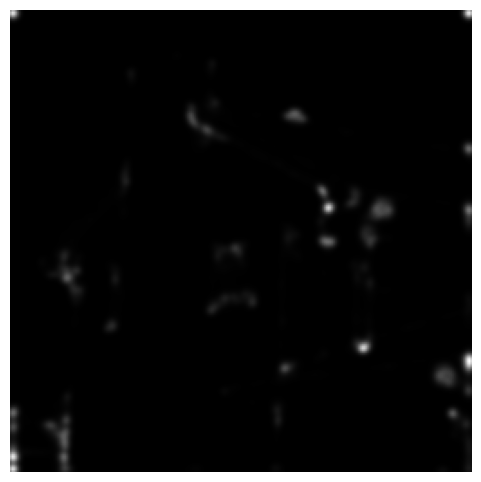

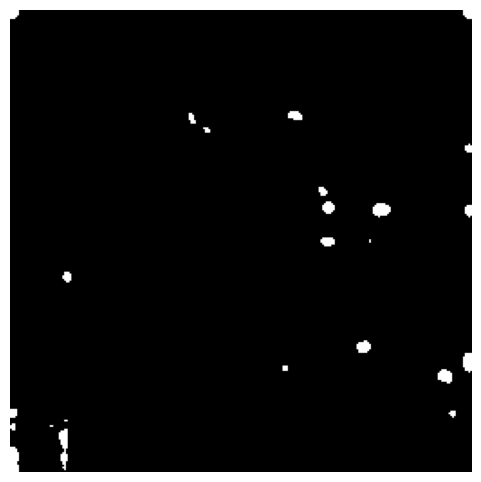

In [63]:
def thresholdR(R, thres):
    """ Array[n, m] * float -> Array[n, m]
    """
    return(np.where(R < thres, 0, 1))
imshow(harryshouse)
imshow(thresholdR(harryshouse,1000000000))

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

In [77]:
def rnms(image_harris):
    """ Array[n, m] -> Array[n, m] 
    """
    #Rbin = thresholdR(image_harris)
    left = image_harris > np.roll(image_harris, 1, axis = 1)
    right =image_harris > np.roll(image_harris, -1, axis = 1)
    up = image_harris > np.roll(image_harris, 1, axis = 0)
    down = image_harris > np.roll(image_harris, -1, axis = 0)
    
    
    RnmSup=np.zeros(image_harris.shape)
    for x in range(image_harris.shape[0]):
        for y in range(image_harris.shape[1]):
            if(left[x,y] and right[x,y] and up[x,y] and down[x,y]):
                RnmSup[x,y]=1
    
    return(RnmSup)


3) Write a function ``cornerDetector(image, scale, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

In [113]:
def cornerDetector(image, sigma, kappa, thres):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """
    R = computeR(image, sigma, kappa)
    Rbin = thresholdR(R, thres)
    rnmsup = rnms(image)
    #imshow(Rbin)
    #imshow(rnmsup)
    res = rnmsup
    res[np.where(Rbin != 1)] = 0
    return res


4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

/tmp/ipykernel_4950/98058304.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n2 = 2*np.int(np.ceil(3*sigma))


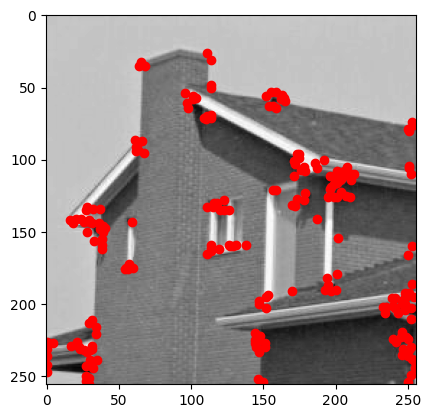

In [138]:
def displayCorner(image, sigma, kappa, thres):
    corner_image=cornerDetector(image,sigma,kappa,thres)
    #imshow(corner_image)
    nonzero = np.nonzero(corner_image)
    plt.scatter(nonzero[1], nonzero[0], c="r")

    plt.imshow(image)
    plt.show()

displayCorner(house,2.3,0.04,10**7.5)



5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

/tmp/ipykernel_4950/2252643845.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n2 = 2*np.int(np.ceil(3*sigma))


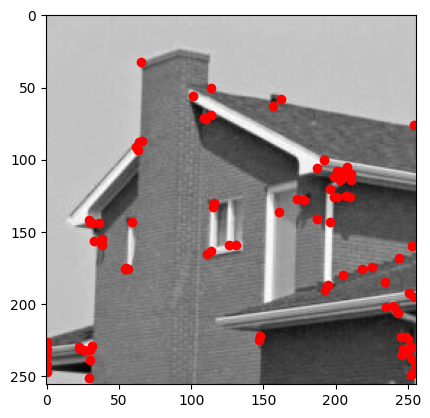

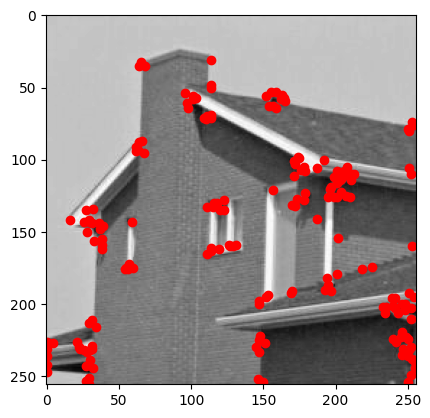

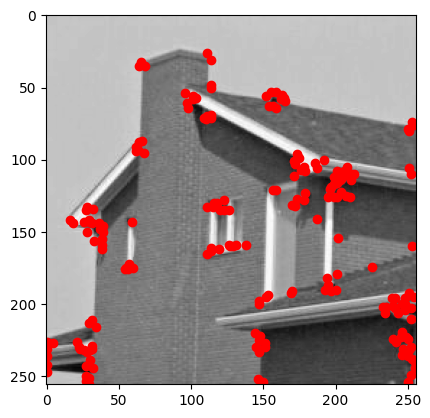

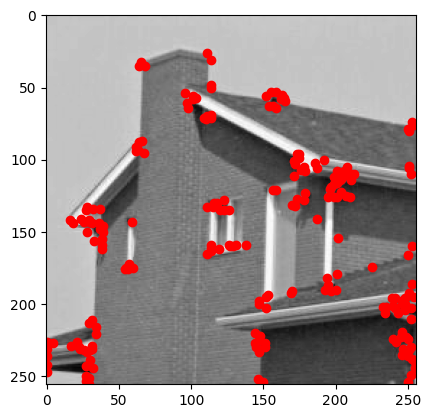

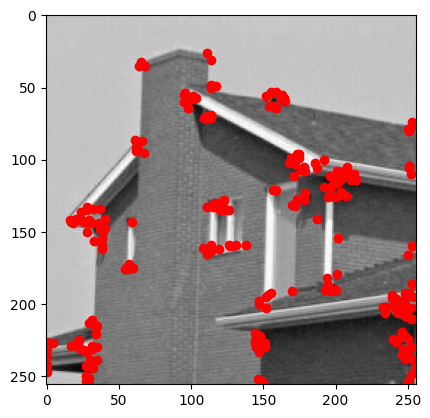

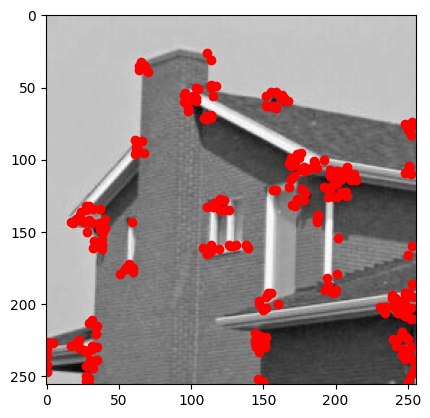

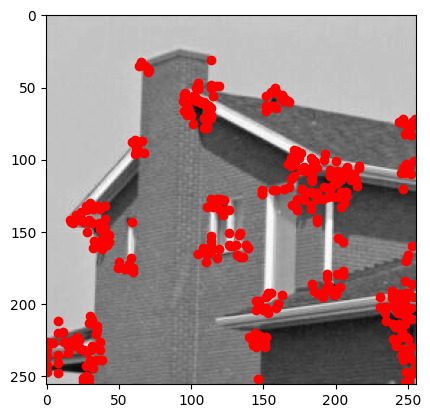

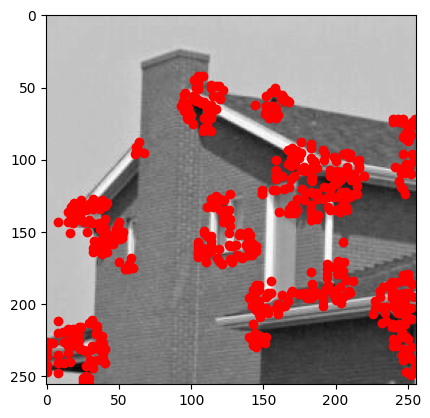

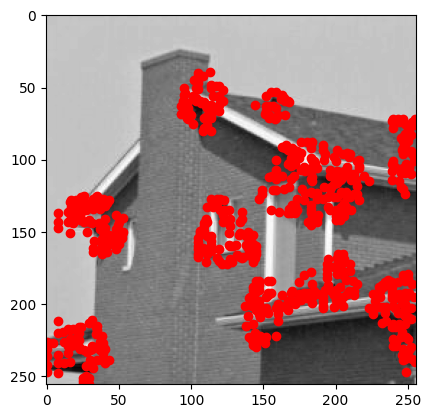

In [140]:
displayCorner(house,1,0.04,10**7.5)
displayCorner(house,2,0.04,10**7.5)
displayCorner(house,2.1,0.04,10**7.5)
displayCorner(house,2.2,0.04,10**7.5)
displayCorner(house,2.5,0.04,10**7.5)
displayCorner(house,3,0.04,10**7.5)
displayCorner(house,5,0.04,10**7.5)
displayCorner(house,8,0.04,10**7.5)
displayCorner(house,10,0.04,10**7.5)

## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

2) What are the dynamic ranges of these two images ?

Your answer...

3) What are the transformations beetween the two images ?

Your answer...

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

Your Answer